In [0]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models #torchvision consists of many popular datasets
import torchvision.models.vgg as models
from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import Variable # for caculating gradients

import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image

from utils.ShipDataset import get_ship_dataset, load_image
from utils.Training import TrainingHelper, PlotReporter, ConsoleReporter

SmallVgg_1:


1.   Inputsize = 80 * 80,

2.   outputsize ...8/8/16/16/32/32/32/64/64/64/128/128/128/FC128/FC128/FC1 stride1


4.   finally in_features[128 * 4 * 4], from feature layer total 1152

5.   total 16 layers

In [0]:
batch_size = 32 #50


In [0]:
train_dataset, valid_dataset = get_ship_dataset("./dataset/class", 10000, validation=0.1)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) #16,50
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

In [6]:
images, labels = next(iter(train_loader))
print(images.size())

torch.Size([32, 3, 80, 80])


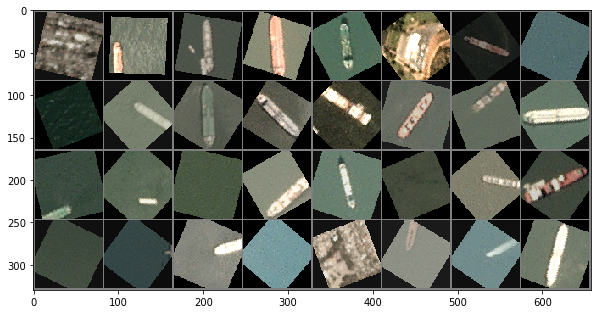

In [7]:
images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [0]:
#SmallVgg16_1 
class SmallVgg16_80(nn.Module):
    def __init__(self):  
        super(SmallVgg16_80, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(8, 16, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=0),

        )
        self.classifier = nn.Sequential(    
                nn.Linear(128 * 4 * 4, 128),  
                # nn.ReLU(True),
                # nn.Dropout(),
                # nn.Linear(128, 128),
                # nn.ReLU(True),
                # nn.Dropout(),
                nn.Linear(128, 1),
                nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
#         return x.view(-1, 1)

SmallVgg16_80 = SmallVgg16_80()

In [74]:
feature = torch.nn.Sequential(*list(SmallVgg16_80.children())[:])
print(feature)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

In [75]:
x = torch.randn(1,3, 80,80)
SmallVgg16_80.features.forward(x).shape

torch.Size([1, 128, 4, 4])

In [86]:
# Test forward pass of the VGG net
inputs, lables = next(iter(train_loader))
x = torch.randn(1, 3, 80,80)
SmallVgg16_80.forward(x)

tensor([[6.2593e-09]], grad_fn=<SigmoidBackward>)

In [87]:

sum([p.numel() for p in SmallVgg16_80.parameters()])

751209

In [0]:
learning_rate = 0.001 #0.02
epoch = 40 

training = TrainingHelper(SmallVgg16_80, nn.BCELoss(), optim.Adam(SmallVgg16_80.parameters(), lr=learning_rate))
training.reporter = PlotReporter(update_interval=5., updates_per_epoch=100, figsize=(15,5))

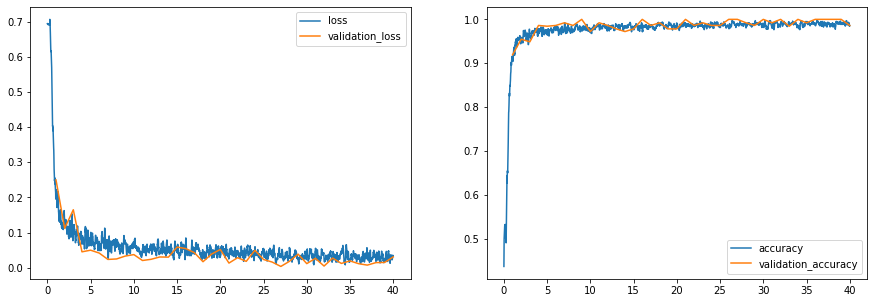

In [81]:
training.fit(epoch,train_loader,valid_loader)

In [82]:
# calculate mean accuracy and loss of the last n validation epochs
n = 10
print("Acc: ", np.mean(training.reporter.val_acc[-n:]))
print("Loss:", np.mean(training.reporter.val_loss[-n:]))

Acc:  0.9954861111111111
Loss: 0.016758504731114954
